In [2]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib

%matplotlib inline

def load_p(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
X_train = load_p("/scratch/pbanerj6/sml-dataset/X_train_all_90.pkl")
X_val = load_p("/scratch/pbanerj6/sml-dataset/X_val_all_90.pkl")
X_test = load_p("/scratch/pbanerj6/sml-dataset/X_test_all_90.pkl")

In [4]:
y_train = load_p("/scratch/pbanerj6/sml-dataset/y_train.p")
y_val = load_p("/scratch/pbanerj6/sml-dataset/y_val.p")
y_test = load_p("/scratch/pbanerj6/sml-dataset/y_test.p")

In [5]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os

In [6]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [7]:
train_dataset = MyDataset(X_train,y_train)
val_dataset = MyDataset(X_val,y_val)
test_dataset = MyDataset(X_test,y_test)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [9]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

def get_model_1():
    N, D_in, H, D_out = 32, 6000, 200, 2
    return torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),)

def get_model_2():
    N , D_in, H1, H2, D_out = 32, 6000, 200, 100, 2
    return torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),)

# model = get_model_1()
# model = get_model_2()

In [10]:
# model.half()

In [11]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [12]:
def train_model(model,limit_train_examples = 100):
    patience = 20
    max_val_acc = 0.0
    model.to('cuda')
    model = torch.nn.DataParallel(model) 
    learning_rate = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    
    loss_fn = nn.CrossEntropyLoss()
    for t in tqdm(range(100),desc="Epoch"):
        model.train()
        total_loss = 0.0
        tmp_acc = 0.0
        steps = 0
        nb_eval_examples = 0
        for x, y in train_loader:
            if nb_eval_examples > limit_train_examples:
                continue
            steps+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits = model(x)
            loss = loss_fn(logits, y)
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            tmp_acc += accuracy(logits, label_ids)
            # Compute and print loss.

            total_loss += loss.mean()
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            nb_eval_examples += x.size(0)

        model.eval()
        val_acc = 0.0
        steps = 0
        nb_val_examples = 0
        for batch_idx, (x, y) in enumerate(val_loader):
            steps+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits = model(x)
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            val_acc += accuracy(logits, label_ids)
            nb_val_examples += x.size(0)

        if max_val_acc < val_acc/nb_val_examples:
            patience = 20
            print("Saving Best Model!!")
            max_val_acc = val_acc/nb_val_examples
            model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
            output_model_file = os.path.join("/scratch/pbanerj6/sml-nn-all-v1/", "best_model.bin")
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            patience-=1

        if patience == 0:
            print("Validation Accuracy Did Not Improve After", patience, "Epochs. Stopping.")
            break
        print("Epoch:",t,"Loss:",total_loss.item()/steps,"Train Accuracy:",(tmp_acc/nb_eval_examples),"Val Accuracy:",(val_acc/nb_val_examples))
    return max_val_acc


In [21]:
from scipy.stats import rankdata
from scipy.special import softmax

from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def mrrVisualization(n_trainSamples,mrrScore):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("NN_All_Linear_Mrr.png")
    plt.show()
    

def precisionVisualization(n_trainSamples,precisionAt1,precisionAt3):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("NN_All_Linear_Precision.png")
    plt.show()

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

def accuracyVisualization(n_trainSamples,valAccuracy,testAccuracy):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("NN_All_Linear_Accuracy.png")
    #plt.show()

qid2c,qid2indexmap = load_ranking("test")


def test_model(model):
    output_model_file = os.path.join("/scratch/pbanerj6/sml-nn-all-v1/", "best_model.bin")
    model.load_state_dict(torch.load(output_model_file))
    model.eval()

    model.to('cuda')
    model = torch.nn.DataParallel(model) 
    model.eval()
    val_acc = 0.0
    steps = 0
    nb_val_examples = 0

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=1,
        pin_memory=True
    )

    all_preds = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x=x.to('cuda')
        y=y.to('cuda')
        logits = model(x)
        logits = logits.detach().cpu().numpy()

        for pred in logits:
            all_preds.append(softmax(pred))

        label_ids = y.to('cpu').numpy()
        val_acc += accuracy(logits, label_ids)
        nb_val_examples += x.size(0)

    mrr = mrrwrapper(qid2c,qid2indexmap,all_preds)
    print("Test Accuracy:",(val_acc/nb_val_examples),"MRR:",(mrr))
    return val_acc/nb_val_examples,mrr[0],mrr[1],mrr[2]

In [14]:
#100 : Test Accuracy: 0.5926666666666667 MRR: (0.5170111111111132, 0.27466666666666667, 0.6733333333333333)
#200 : Test Accuracy: 0.5921333333333333 MRR: (0.5180888888888906, 0.27666666666666667, 0.6706666666666666)
# 200-100 : Test Accuracy: 0.5925333333333334 MRR: (0.5254666666666686, 0.2866666666666667, 0.6786666666666666)
# 200-100 : Test Accuracy: 0.5940666666666666 MRR: (0.5177444444444464, 0.276, 0.676)

In [15]:
# Run Orchestrator:
train_samples = [100,1000,10000,20000,50000]
val_accuracies = []
test_accuracies = []
mrr_vals = []
p1s = []
p3s = []

for train_sample in train_samples:
    model = get_model_1()
    # model = get_model_2()
    val_accuracies.append(train_model(model,train_sample))
    del model
    model = get_model_1()
    # model = get_model_2()
    test_acc,mrr,p1,p3=test_model(model)
    test_accuracies.append(test_acc)
    mrr_vals.append(mrr)
    p1s.append(p1)
    p3s.append(p3)
    del model

Epoch:   1%|          | 1/100 [00:28<47:31, 28.81s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.0061684417317925235 Train Accuracy: 0.4921875 Val Accuracy: 0.5053333333333333
Saving Best Model!!


Epoch:   2%|▏         | 2/100 [00:48<42:48, 26.21s/it]

Epoch: 1 Loss: 0.006625224786526613 Train Accuracy: 0.5390625 Val Accuracy: 0.5056666666666667


Epoch:   3%|▎         | 3/100 [00:57<33:34, 20.77s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.006090793528282312 Train Accuracy: 0.515625 Val Accuracy: 0.5092


Epoch:   4%|▍         | 4/100 [01:04<27:04, 16.92s/it]

Epoch: 3 Loss: 0.006303678951792117 Train Accuracy: 0.46875 Val Accuracy: 0.5090666666666667


Epoch:   5%|▌         | 5/100 [01:12<22:29, 14.20s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.006493870891741852 Train Accuracy: 0.4453125 Val Accuracy: 0.5106


Epoch:   6%|▌         | 6/100 [01:20<19:17, 12.32s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.006331063536946961 Train Accuracy: 0.484375 Val Accuracy: 0.5120666666666667


Epoch:   7%|▋         | 7/100 [01:28<17:08, 11.06s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.006088116529908007 Train Accuracy: 0.5390625 Val Accuracy: 0.5140666666666667


Epoch:   8%|▊         | 8/100 [01:36<15:32, 10.13s/it]

Saving Best Model!!
Epoch: 7 Loss: 0.00588295200486173 Train Accuracy: 0.5859375 Val Accuracy: 0.5155333333333333


Epoch:   9%|▉         | 9/100 [01:44<14:20,  9.45s/it]

Saving Best Model!!
Epoch: 8 Loss: 0.006235189783547733 Train Accuracy: 0.484375 Val Accuracy: 0.5175333333333333


Epoch:  10%|█         | 10/100 [01:52<13:30,  9.01s/it]

Saving Best Model!!
Epoch: 9 Loss: 0.00619589240312068 Train Accuracy: 0.5625 Val Accuracy: 0.5199333333333334


Epoch:  11%|█         | 11/100 [02:00<12:56,  8.73s/it]

Saving Best Model!!
Epoch: 10 Loss: 0.006066458565848214 Train Accuracy: 0.53125 Val Accuracy: 0.5209333333333334


Epoch:  12%|█▏        | 12/100 [02:07<12:00,  8.19s/it]

Saving Best Model!!
Epoch: 11 Loss: 0.006257029738761723 Train Accuracy: 0.5078125 Val Accuracy: 0.5215333333333333


Epoch:  13%|█▎        | 13/100 [02:14<11:24,  7.87s/it]

Saving Best Model!!
Epoch: 12 Loss: 0.006218850231373996 Train Accuracy: 0.4921875 Val Accuracy: 0.5242


Epoch:  14%|█▍        | 14/100 [02:21<10:55,  7.62s/it]

Saving Best Model!!
Epoch: 13 Loss: 0.0065359484666446125 Train Accuracy: 0.46875 Val Accuracy: 0.5261333333333333


Epoch:  15%|█▌        | 15/100 [02:28<10:31,  7.43s/it]

Saving Best Model!!
Epoch: 14 Loss: 0.005774991598718964 Train Accuracy: 0.609375 Val Accuracy: 0.5268


Epoch:  16%|█▌        | 16/100 [02:35<10:13,  7.31s/it]

Saving Best Model!!
Epoch: 15 Loss: 0.005931996587497085 Train Accuracy: 0.5390625 Val Accuracy: 0.527


Epoch:  17%|█▋        | 17/100 [02:42<09:56,  7.18s/it]

Saving Best Model!!
Epoch: 16 Loss: 0.006189667593949893 Train Accuracy: 0.53125 Val Accuracy: 0.5286


Epoch:  18%|█▊        | 18/100 [02:49<09:40,  7.08s/it]

Saving Best Model!!
Epoch: 17 Loss: 0.005576113902175351 Train Accuracy: 0.6484375 Val Accuracy: 0.5288


Epoch:  19%|█▉        | 19/100 [02:56<09:26,  6.99s/it]

Saving Best Model!!
Epoch: 18 Loss: 0.006092639874293606 Train Accuracy: 0.5 Val Accuracy: 0.5297333333333333


Epoch:  20%|██        | 20/100 [03:03<09:14,  6.93s/it]

Saving Best Model!!
Epoch: 19 Loss: 0.006121691356081444 Train Accuracy: 0.546875 Val Accuracy: 0.5317333333333333


Epoch:  21%|██        | 21/100 [03:10<09:08,  6.95s/it]

Saving Best Model!!
Epoch: 20 Loss: 0.006530477548204759 Train Accuracy: 0.484375 Val Accuracy: 0.5318


Epoch:  22%|██▏       | 22/100 [03:17<09:10,  7.06s/it]

Saving Best Model!!
Epoch: 21 Loss: 0.00598017289948616 Train Accuracy: 0.578125 Val Accuracy: 0.5322


Epoch:  23%|██▎       | 23/100 [03:24<09:05,  7.09s/it]

Saving Best Model!!
Epoch: 22 Loss: 0.005824919702655979 Train Accuracy: 0.6015625 Val Accuracy: 0.5324666666666666


Epoch:  24%|██▍       | 24/100 [03:31<08:59,  7.10s/it]

Epoch: 23 Loss: 0.005693527681232769 Train Accuracy: 0.609375 Val Accuracy: 0.5322


Epoch:  25%|██▌       | 25/100 [03:38<08:50,  7.08s/it]

Saving Best Model!!
Epoch: 24 Loss: 0.006072614747069792 Train Accuracy: 0.5078125 Val Accuracy: 0.5333333333333333


Epoch:  26%|██▌       | 26/100 [03:45<08:43,  7.07s/it]

Saving Best Model!!
Epoch: 25 Loss: 0.0060789702035216634 Train Accuracy: 0.546875 Val Accuracy: 0.5337333333333333


Epoch:  27%|██▋       | 27/100 [03:52<08:33,  7.04s/it]

Saving Best Model!!
Epoch: 26 Loss: 0.006248672379613685 Train Accuracy: 0.5546875 Val Accuracy: 0.5343333333333333


Epoch:  28%|██▊       | 28/100 [03:59<08:24,  7.00s/it]

Saving Best Model!!
Epoch: 27 Loss: 0.005672726295650132 Train Accuracy: 0.625 Val Accuracy: 0.5362


Epoch:  29%|██▉       | 29/100 [04:06<08:19,  7.03s/it]

Saving Best Model!!
Epoch: 28 Loss: 0.006075894146331592 Train Accuracy: 0.5234375 Val Accuracy: 0.5376666666666666


Epoch:  30%|███       | 30/100 [04:13<08:12,  7.04s/it]

Saving Best Model!!
Epoch: 29 Loss: 0.005928364898096015 Train Accuracy: 0.546875 Val Accuracy: 0.539


Epoch:  31%|███       | 31/100 [04:20<08:06,  7.05s/it]

Saving Best Model!!
Epoch: 30 Loss: 0.006067121461002049 Train Accuracy: 0.59375 Val Accuracy: 0.54


Epoch:  32%|███▏      | 32/100 [04:28<08:02,  7.10s/it]

Saving Best Model!!
Epoch: 31 Loss: 0.005877817109195408 Train Accuracy: 0.5625 Val Accuracy: 0.5409333333333334


Epoch:  33%|███▎      | 33/100 [04:35<07:58,  7.14s/it]

Saving Best Model!!
Epoch: 32 Loss: 0.005959496569277635 Train Accuracy: 0.5390625 Val Accuracy: 0.5424


Epoch:  34%|███▍      | 34/100 [04:42<07:51,  7.14s/it]

Epoch: 33 Loss: 0.005770437244667428 Train Accuracy: 0.578125 Val Accuracy: 0.5417333333333333


Epoch:  35%|███▌      | 35/100 [04:50<07:57,  7.35s/it]

Epoch: 34 Loss: 0.0059431880267698375 Train Accuracy: 0.578125 Val Accuracy: 0.5414666666666667


Epoch:  36%|███▌      | 36/100 [04:58<08:04,  7.56s/it]

Epoch: 35 Loss: 0.00555781565749569 Train Accuracy: 0.6328125 Val Accuracy: 0.5402


Epoch:  37%|███▋      | 37/100 [05:06<07:59,  7.61s/it]

Epoch: 36 Loss: 0.005635803442265688 Train Accuracy: 0.6015625 Val Accuracy: 0.5403333333333333


Epoch:  38%|███▊      | 38/100 [05:14<07:58,  7.71s/it]

Epoch: 37 Loss: 0.005807163872952654 Train Accuracy: 0.5625 Val Accuracy: 0.5407333333333333


Epoch:  39%|███▉      | 39/100 [05:21<07:52,  7.75s/it]

Saving Best Model!!
Epoch: 38 Loss: 0.0060576040353348005 Train Accuracy: 0.5 Val Accuracy: 0.5424666666666667


Epoch:  40%|████      | 40/100 [05:29<07:50,  7.84s/it]

Saving Best Model!!
Epoch: 39 Loss: 0.0060056811456741304 Train Accuracy: 0.5078125 Val Accuracy: 0.5428


Epoch:  41%|████      | 41/100 [05:37<07:44,  7.87s/it]

Saving Best Model!!
Epoch: 40 Loss: 0.006009206080487542 Train Accuracy: 0.5234375 Val Accuracy: 0.5432


Epoch:  42%|████▏     | 42/100 [05:45<07:35,  7.85s/it]

Saving Best Model!!
Epoch: 41 Loss: 0.006278236283422279 Train Accuracy: 0.5390625 Val Accuracy: 0.5435333333333333


Epoch:  43%|████▎     | 43/100 [05:53<07:29,  7.89s/it]

Saving Best Model!!
Epoch: 42 Loss: 0.00610434627736301 Train Accuracy: 0.53125 Val Accuracy: 0.545


Epoch:  44%|████▍     | 44/100 [06:01<07:22,  7.91s/it]

Saving Best Model!!
Epoch: 43 Loss: 0.006198219653131611 Train Accuracy: 0.5 Val Accuracy: 0.5456666666666666
Saving Best Model!!


Epoch:  45%|████▌     | 45/100 [06:09<07:15,  7.91s/it]

Epoch: 44 Loss: 0.0055450305247357655 Train Accuracy: 0.6640625 Val Accuracy: 0.5473333333333333


Epoch:  46%|████▌     | 46/100 [06:17<07:09,  7.95s/it]

Saving Best Model!!
Epoch: 45 Loss: 0.005854234512426706 Train Accuracy: 0.6328125 Val Accuracy: 0.5493333333333333


Epoch:  47%|████▋     | 47/100 [06:25<07:04,  8.01s/it]

Saving Best Model!!
Epoch: 46 Loss: 0.005928015149732643 Train Accuracy: 0.4921875 Val Accuracy: 0.5509333333333334


Epoch:  48%|████▊     | 48/100 [06:33<06:53,  7.96s/it]

Saving Best Model!!
Epoch: 47 Loss: 0.005679476744076336 Train Accuracy: 0.6484375 Val Accuracy: 0.5516666666666666


Epoch:  49%|████▉     | 49/100 [06:41<06:43,  7.91s/it]

Saving Best Model!!
Epoch: 48 Loss: 0.0058882114475469855 Train Accuracy: 0.546875 Val Accuracy: 0.5518


Epoch:  50%|█████     | 50/100 [06:49<06:35,  7.90s/it]

Epoch: 49 Loss: 0.006086576213714665 Train Accuracy: 0.5625 Val Accuracy: 0.5514


Epoch:  51%|█████     | 51/100 [06:57<06:30,  7.98s/it]

Saving Best Model!!
Epoch: 50 Loss: 0.0057021010913320186 Train Accuracy: 0.6015625 Val Accuracy: 0.5526


Epoch:  52%|█████▏    | 52/100 [07:05<06:20,  7.92s/it]

Epoch: 51 Loss: 0.005457359590510061 Train Accuracy: 0.671875 Val Accuracy: 0.5522666666666667


Epoch:  53%|█████▎    | 53/100 [07:12<06:09,  7.87s/it]

Saving Best Model!!
Epoch: 52 Loss: 0.005548053204632009 Train Accuracy: 0.578125 Val Accuracy: 0.5534666666666667


Epoch:  54%|█████▍    | 54/100 [07:20<06:00,  7.84s/it]

Saving Best Model!!
Epoch: 53 Loss: 0.00561244147164481 Train Accuracy: 0.6171875 Val Accuracy: 0.5541333333333334
Saving Best Model!!


Epoch:  55%|█████▌    | 55/100 [07:28<05:45,  7.68s/it]

Epoch: 54 Loss: 0.005640659250938562 Train Accuracy: 0.5859375 Val Accuracy: 0.5544666666666667


Epoch:  56%|█████▌    | 56/100 [07:35<05:32,  7.55s/it]

Saving Best Model!!
Epoch: 55 Loss: 0.005749547913638768 Train Accuracy: 0.6015625 Val Accuracy: 0.555


Epoch:  57%|█████▋    | 57/100 [07:42<05:19,  7.43s/it]

Saving Best Model!!
Epoch: 56 Loss: 0.005927795540295176 Train Accuracy: 0.578125 Val Accuracy: 0.5559333333333333


Epoch:  58%|█████▊    | 58/100 [07:49<05:10,  7.39s/it]

Saving Best Model!!
Epoch: 57 Loss: 0.00594971479891714 Train Accuracy: 0.5390625 Val Accuracy: 0.5572
Saving Best Model!!


Epoch:  59%|█████▉    | 59/100 [08:01<06:01,  8.82s/it]

Epoch: 58 Loss: 0.005456464885394456 Train Accuracy: 0.6640625 Val Accuracy: 0.5582


Epoch:  60%|██████    | 60/100 [08:08<05:30,  8.26s/it]

Saving Best Model!!
Epoch: 59 Loss: 0.005965787972976912 Train Accuracy: 0.578125 Val Accuracy: 0.5584


Epoch:  61%|██████    | 61/100 [08:15<05:08,  7.90s/it]

Saving Best Model!!
Epoch: 60 Loss: 0.0054435562223259576 Train Accuracy: 0.6484375 Val Accuracy: 0.5593333333333333


Epoch:  62%|██████▏   | 62/100 [08:22<04:50,  7.63s/it]

Saving Best Model!!
Epoch: 61 Loss: 0.005784170968191964 Train Accuracy: 0.609375 Val Accuracy: 0.5608666666666666


Epoch:  63%|██████▎   | 63/100 [08:30<04:38,  7.52s/it]

Epoch: 62 Loss: 0.005845754639680452 Train Accuracy: 0.5625 Val Accuracy: 0.5599333333333333
Saving Best Model!!


Epoch:  64%|██████▍   | 64/100 [08:41<05:08,  8.57s/it]

Epoch: 63 Loss: 0.006076690230542409 Train Accuracy: 0.515625 Val Accuracy: 0.5616666666666666


Epoch:  65%|██████▌   | 65/100 [08:48<04:41,  8.06s/it]

Saving Best Model!!
Epoch: 64 Loss: 0.005608395472772594 Train Accuracy: 0.640625 Val Accuracy: 0.5623333333333334


Epoch:  66%|██████▌   | 66/100 [08:55<04:24,  7.79s/it]

Saving Best Model!!
Epoch: 65 Loss: 0.005532505161472475 Train Accuracy: 0.6171875 Val Accuracy: 0.5631333333333334


Epoch:  67%|██████▋   | 67/100 [09:02<04:11,  7.63s/it]

Saving Best Model!!
Epoch: 66 Loss: 0.005607764095639877 Train Accuracy: 0.640625 Val Accuracy: 0.5638


Epoch:  68%|██████▊   | 68/100 [09:09<03:59,  7.49s/it]

Saving Best Model!!
Epoch: 67 Loss: 0.0055284515372725695 Train Accuracy: 0.6640625 Val Accuracy: 0.5648


Epoch:  69%|██████▉   | 69/100 [09:16<03:48,  7.37s/it]

Saving Best Model!!
Epoch: 68 Loss: 0.005936075121100778 Train Accuracy: 0.5703125 Val Accuracy: 0.5657333333333333


Epoch:  70%|███████   | 70/100 [09:23<03:38,  7.28s/it]

Saving Best Model!!
Epoch: 69 Loss: 0.00571763591725689 Train Accuracy: 0.625 Val Accuracy: 0.5662666666666667


Epoch:  71%|███████   | 71/100 [09:30<03:30,  7.24s/it]

Saving Best Model!!
Epoch: 70 Loss: 0.005215850720273406 Train Accuracy: 0.6796875 Val Accuracy: 0.5677333333333333


Epoch:  72%|███████▏  | 72/100 [09:38<03:22,  7.22s/it]

Epoch: 71 Loss: 0.006039825838003585 Train Accuracy: 0.53125 Val Accuracy: 0.5677333333333333


Epoch:  73%|███████▎  | 73/100 [09:45<03:14,  7.19s/it]

Saving Best Model!!
Epoch: 72 Loss: 0.005856616156441825 Train Accuracy: 0.625 Val Accuracy: 0.5682666666666667


Epoch:  74%|███████▍  | 74/100 [09:52<03:06,  7.18s/it]

Saving Best Model!!
Epoch: 73 Loss: 0.0057615013773253225 Train Accuracy: 0.578125 Val Accuracy: 0.5683333333333334


Epoch:  75%|███████▌  | 75/100 [09:59<02:59,  7.19s/it]

Epoch: 74 Loss: 0.00561797440941654 Train Accuracy: 0.5703125 Val Accuracy: 0.5679333333333333


Epoch:  76%|███████▌  | 76/100 [10:07<02:59,  7.47s/it]

Saving Best Model!!
Epoch: 75 Loss: 0.005571538705561461 Train Accuracy: 0.625 Val Accuracy: 0.5688666666666666


Epoch:  77%|███████▋  | 77/100 [10:15<02:54,  7.58s/it]

Saving Best Model!!
Epoch: 76 Loss: 0.005730029108173557 Train Accuracy: 0.6015625 Val Accuracy: 0.5702666666666667


Epoch:  78%|███████▊  | 78/100 [10:23<02:47,  7.63s/it]

Saving Best Model!!
Epoch: 77 Loss: 0.005585262770337591 Train Accuracy: 0.6328125 Val Accuracy: 0.571


Epoch:  79%|███████▉  | 79/100 [10:31<02:40,  7.66s/it]

Saving Best Model!!
Epoch: 78 Loss: 0.005735375987949656 Train Accuracy: 0.59375 Val Accuracy: 0.5721333333333334


Epoch:  80%|████████  | 80/100 [10:39<02:37,  7.86s/it]

Saving Best Model!!
Epoch: 79 Loss: 0.005767360679122177 Train Accuracy: 0.6484375 Val Accuracy: 0.5732666666666667


Epoch:  81%|████████  | 81/100 [10:47<02:30,  7.94s/it]

Epoch: 80 Loss: 0.005571793391506301 Train Accuracy: 0.640625 Val Accuracy: 0.5732


Epoch:  82%|████████▏ | 82/100 [10:55<02:23,  7.98s/it]

Saving Best Model!!
Epoch: 81 Loss: 0.0057954849210629334 Train Accuracy: 0.5703125 Val Accuracy: 0.5745333333333333


Epoch:  83%|████████▎ | 83/100 [11:03<02:14,  7.91s/it]

Saving Best Model!!
Epoch: 82 Loss: 0.005765085789694715 Train Accuracy: 0.6015625 Val Accuracy: 0.5748666666666666


Epoch:  84%|████████▍ | 84/100 [11:11<02:05,  7.85s/it]

Saving Best Model!!
Epoch: 83 Loss: 0.005511780537521915 Train Accuracy: 0.59375 Val Accuracy: 0.5762666666666667


Epoch:  85%|████████▌ | 85/100 [11:19<01:58,  7.92s/it]

Saving Best Model!!
Epoch: 84 Loss: 0.005619072456603874 Train Accuracy: 0.578125 Val Accuracy: 0.5765333333333333


Epoch:  86%|████████▌ | 86/100 [11:27<01:51,  7.95s/it]

Saving Best Model!!
Epoch: 85 Loss: 0.005708372669179302 Train Accuracy: 0.578125 Val Accuracy: 0.5781333333333334


Epoch:  87%|████████▋ | 87/100 [11:35<01:44,  8.01s/it]

Epoch: 86 Loss: 0.0052095928680159645 Train Accuracy: 0.6796875 Val Accuracy: 0.5762666666666667


Epoch:  88%|████████▊ | 88/100 [11:43<01:35,  7.99s/it]

Epoch: 87 Loss: 0.00568061240954694 Train Accuracy: 0.578125 Val Accuracy: 0.5761333333333334


Epoch:  89%|████████▉ | 89/100 [11:51<01:27,  7.96s/it]

Epoch: 88 Loss: 0.005463304295977041 Train Accuracy: 0.6953125 Val Accuracy: 0.5764


Epoch:  90%|█████████ | 90/100 [11:59<01:19,  7.99s/it]

Epoch: 89 Loss: 0.0054914041368691905 Train Accuracy: 0.65625 Val Accuracy: 0.5773333333333334


Epoch:  91%|█████████ | 91/100 [12:07<01:11,  7.96s/it]

Saving Best Model!!
Epoch: 90 Loss: 0.005674470462270383 Train Accuracy: 0.640625 Val Accuracy: 0.5794666666666667


Epoch:  92%|█████████▏| 92/100 [12:14<01:03,  7.90s/it]

Saving Best Model!!
Epoch: 91 Loss: 0.005289972972259847 Train Accuracy: 0.6875 Val Accuracy: 0.5796666666666667


Epoch:  93%|█████████▎| 93/100 [12:22<00:54,  7.81s/it]

Saving Best Model!!
Epoch: 92 Loss: 0.005497468814158491 Train Accuracy: 0.6015625 Val Accuracy: 0.5808


Epoch:  94%|█████████▍| 94/100 [12:30<00:47,  7.90s/it]

Saving Best Model!!
Epoch: 93 Loss: 0.005286860313496864 Train Accuracy: 0.671875 Val Accuracy: 0.5813333333333334


Epoch:  95%|█████████▌| 95/100 [12:38<00:40,  8.04s/it]

Saving Best Model!!
Epoch: 94 Loss: 0.00534038096348614 Train Accuracy: 0.65625 Val Accuracy: 0.5824


Epoch:  96%|█████████▌| 96/100 [12:47<00:32,  8.15s/it]

Epoch: 95 Loss: 0.0055612572220596936 Train Accuracy: 0.6484375 Val Accuracy: 0.5816


Epoch:  97%|█████████▋| 97/100 [12:54<00:23,  7.87s/it]

Epoch: 96 Loss: 0.005817473824344464 Train Accuracy: 0.546875 Val Accuracy: 0.5824


Epoch:  98%|█████████▊| 98/100 [13:01<00:15,  7.73s/it]

Saving Best Model!!
Epoch: 97 Loss: 0.005688224011646913 Train Accuracy: 0.6015625 Val Accuracy: 0.5834666666666667


Epoch:  99%|█████████▉| 99/100 [13:09<00:07,  7.62s/it]

Saving Best Model!!
Epoch: 98 Loss: 0.005585272429085998 Train Accuracy: 0.640625 Val Accuracy: 0.5844


Epoch: 100%|██████████| 100/100 [13:16<00:00,  7.50s/it]

Saving Best Model!!
Epoch: 99 Loss: 0.005363859855798262 Train Accuracy: 0.6640625 Val Accuracy: 0.5858



Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.5722666666666667 MRR: (0.5080000000000019, 0.272, 0.6493333333333333)


Epoch:   1%|          | 1/100 [00:07<12:07,  7.35s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.04970317100411031 Train Accuracy: 0.47265625 Val Accuracy: 0.4992


Epoch:   2%|▏         | 2/100 [00:14<12:01,  7.36s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.04941973655716951 Train Accuracy: 0.509765625 Val Accuracy: 0.5084
Saving Best Model!!
Epoch: 

Epoch:   3%|▎         | 3/100 [00:21<11:50,  7.32s/it]

2 Loss: 0.046919816592608944 Train Accuracy: 0.548828125 Val Accuracy: 0.5142666666666666


Epoch:   4%|▍         | 4/100 [00:29<11:37,  7.26s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.04796741054510511 Train Accuracy: 0.51953125 Val Accuracy: 0.5234


Epoch:   5%|▌         | 5/100 [00:36<11:27,  7.24s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.047627072852811835 Train Accuracy: 0.5634765625 Val Accuracy: 0.5320666666666667


Epoch:   6%|▌         | 6/100 [00:43<11:28,  7.33s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.04610210898588461 Train Accuracy: 0.556640625 Val Accuracy: 0.5358666666666667


Epoch:   7%|▋         | 7/100 [00:51<11:25,  7.37s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.046707584405504564 Train Accuracy: 0.587890625 Val Accuracy: 0.5441333333333334


Epoch:   8%|▊         | 8/100 [00:58<11:17,  7.37s/it]

Saving Best Model!!
Epoch: 7 Loss: 0.04534552600592184 Train Accuracy: 0.591796875 Val Accuracy: 0.5535333333333333


Epoch:   9%|▉         | 9/100 [01:05<11:07,  7.33s/it]

Saving Best Model!!
Epoch: 8 Loss: 0.04555143018775403 Train Accuracy: 0.5869140625 Val Accuracy: 0.563


Epoch:  10%|█         | 10/100 [01:13<10:57,  7.30s/it]

Saving Best Model!!
Epoch: 9 Loss: 0.045090392708524205 Train Accuracy: 0.6083984375 Val Accuracy: 0.5698


Epoch:  11%|█         | 11/100 [01:20<10:47,  7.28s/it]

Saving Best Model!!
Epoch: 10 Loss: 0.04451649224580224 Train Accuracy: 0.6533203125 Val Accuracy: 0.5708


Epoch:  12%|█▏        | 12/100 [01:27<10:41,  7.29s/it]

Saving Best Model!!
Epoch: 11 Loss: 0.04550892762792136 Train Accuracy: 0.6044921875 Val Accuracy: 0.5778


Epoch:  13%|█▎        | 13/100 [01:34<10:34,  7.29s/it]

Saving Best Model!!
Epoch: 12 Loss: 0.04382658919800065 Train Accuracy: 0.6435546875 Val Accuracy: 0.588


Epoch:  14%|█▍        | 14/100 [01:42<10:27,  7.30s/it]

Saving Best Model!!
Epoch: 13 Loss: 0.0435948077041203 Train Accuracy: 0.6298828125 Val Accuracy: 0.5908666666666667


Epoch:  15%|█▌        | 15/100 [01:49<10:16,  7.25s/it]

Saving Best Model!!
Epoch: 14 Loss: 0.04314019583435709 Train Accuracy: 0.654296875 Val Accuracy: 0.5948666666666667


Epoch:  16%|█▌        | 16/100 [01:56<10:13,  7.31s/it]

Saving Best Model!!
Epoch: 15 Loss: 0.043352131142036746 Train Accuracy: 0.6591796875 Val Accuracy: 0.5977333333333333
Saving Best Model!!


Epoch:  17%|█▋        | 17/100 [02:05<10:29,  7.59s/it]

Epoch: 16 Loss: 0.04156963047442406 Train Accuracy: 0.685546875 Val Accuracy: 0.6020666666666666


Epoch:  18%|█▊        | 18/100 [02:13<10:34,  7.74s/it]

Saving Best Model!!
Epoch: 17 Loss: 0.04170069664017732 Train Accuracy: 0.6923828125 Val Accuracy: 0.6028


Epoch:  19%|█▉        | 19/100 [02:21<10:32,  7.80s/it]

Epoch: 18 Loss: 0.04243972306566706 Train Accuracy: 0.673828125 Val Accuracy: 0.6026
Saving Best Model!!


Epoch:  20%|██        | 20/100 [02:36<13:30, 10.13s/it]

Epoch: 19 Loss: 0.04141223151038196 Train Accuracy: 0.705078125 Val Accuracy: 0.6068


Epoch:  21%|██        | 21/100 [02:44<12:36,  9.58s/it]

Saving Best Model!!
Epoch: 20 Loss: 0.04174502114497268 Train Accuracy: 0.6708984375 Val Accuracy: 0.6115333333333334


Epoch:  22%|██▏       | 22/100 [02:53<12:02,  9.27s/it]

Saving Best Model!!
Epoch: 21 Loss: 0.04112275780391083 Train Accuracy: 0.712890625 Val Accuracy: 0.6134666666666667


Epoch:  23%|██▎       | 23/100 [03:01<11:28,  8.94s/it]

Saving Best Model!!
Epoch: 22 Loss: 0.04042071930126849 Train Accuracy: 0.716796875 Val Accuracy: 0.6178666666666667


Epoch:  24%|██▍       | 24/100 [03:09<10:57,  8.65s/it]

Saving Best Model!!
Epoch: 23 Loss: 0.04070392193824752 Train Accuracy: 0.69140625 Val Accuracy: 0.6189333333333333


Epoch:  25%|██▌       | 25/100 [03:17<10:29,  8.39s/it]

Epoch: 24 Loss: 0.04026225482477054 Train Accuracy: 0.69921875 Val Accuracy: 0.6171333333333333


Epoch:  26%|██▌       | 26/100 [03:25<10:14,  8.31s/it]

Epoch: 25 Loss: 0.04087669356291228 Train Accuracy: 0.7080078125 Val Accuracy: 0.615


Epoch:  27%|██▋       | 27/100 [03:33<10:06,  8.31s/it]

Epoch: 26 Loss: 0.039433221064650935 Train Accuracy: 0.7197265625 Val Accuracy: 0.6184


Epoch:  28%|██▊       | 28/100 [03:42<09:57,  8.29s/it]

Saving Best Model!!
Epoch: 27 Loss: 0.038517238234660266 Train Accuracy: 0.748046875 Val Accuracy: 0.6226


Epoch:  29%|██▉       | 29/100 [03:50<09:56,  8.41s/it]

Saving Best Model!!
Epoch: 28 Loss: 0.03881147827929271 Train Accuracy: 0.7353515625 Val Accuracy: 0.6245333333333334


Epoch:  30%|███       | 30/100 [03:59<09:48,  8.41s/it]

Saving Best Model!!
Epoch: 29 Loss: 0.03884766910121893 Train Accuracy: 0.73828125 Val Accuracy: 0.6259333333333333


Epoch:  31%|███       | 31/100 [04:07<09:39,  8.39s/it]

Epoch: 30 Loss: 0.038581567532472265 Train Accuracy: 0.7294921875 Val Accuracy: 0.6250666666666667


Epoch:  32%|███▏      | 32/100 [04:15<09:26,  8.34s/it]

Saving Best Model!!
Epoch: 31 Loss: 0.03998256593879098 Train Accuracy: 0.701171875 Val Accuracy: 0.6261333333333333


Epoch:  33%|███▎      | 33/100 [04:23<09:13,  8.26s/it]

Saving Best Model!!
Epoch: 32 Loss: 0.037823248011216934 Train Accuracy: 0.740234375 Val Accuracy: 0.6294


Epoch:  34%|███▍      | 34/100 [04:31<09:01,  8.21s/it]

Epoch: 33 Loss: 0.03752837760616213 Train Accuracy: 0.7548828125 Val Accuracy: 0.6279333333333333


Epoch:  35%|███▌      | 35/100 [04:39<08:49,  8.15s/it]

Saving Best Model!!
Epoch: 34 Loss: 0.03799189179182561 Train Accuracy: 0.7529296875 Val Accuracy: 0.6300666666666667


Epoch:  36%|███▌      | 36/100 [04:48<08:46,  8.22s/it]

Saving Best Model!!
Epoch: 35 Loss: 0.03753337982112665 Train Accuracy: 0.744140625 Val Accuracy: 0.6321333333333333


Epoch:  37%|███▋      | 37/100 [04:55<08:24,  8.01s/it]

Epoch: 36 Loss: 0.03770348359781033 Train Accuracy: 0.7548828125 Val Accuracy: 0.6316


Epoch:  38%|███▊      | 38/100 [05:03<08:05,  7.82s/it]

Saving Best Model!!
Epoch: 37 Loss: 0.03708411991469133 Train Accuracy: 0.755859375 Val Accuracy: 0.6354


Epoch:  39%|███▉      | 39/100 [05:10<07:47,  7.66s/it]

Saving Best Model!!
Epoch: 38 Loss: 0.03664144829138002 Train Accuracy: 0.7607421875 Val Accuracy: 0.6374


Epoch:  40%|████      | 40/100 [05:17<07:32,  7.54s/it]

Saving Best Model!!
Epoch: 39 Loss: 0.037585768872486755 Train Accuracy: 0.7451171875 Val Accuracy: 0.6405333333333333


Epoch:  41%|████      | 41/100 [05:25<07:19,  7.45s/it]

Epoch: 40 Loss: 0.03640603104125716 Train Accuracy: 0.73828125 Val Accuracy: 0.6382


Epoch:  42%|████▏     | 42/100 [05:32<07:09,  7.40s/it]

Epoch: 41 Loss: 0.036600068179783285 Train Accuracy: 0.7587890625 Val Accuracy: 0.6399333333333334


Epoch:  43%|████▎     | 43/100 [05:39<07:01,  7.39s/it]

Saving Best Model!!
Epoch: 42 Loss: 0.03700830585666811 Train Accuracy: 0.759765625 Val Accuracy: 0.6424666666666666


Epoch:  44%|████▍     | 44/100 [05:46<06:52,  7.36s/it]

Epoch: 43 Loss: 0.036525063423205544 Train Accuracy: 0.7607421875 Val Accuracy: 0.6422666666666667


Epoch:  45%|████▌     | 45/100 [05:54<06:42,  7.32s/it]

Saving Best Model!!
Epoch: 44 Loss: 0.035918412686410994 Train Accuracy: 0.7626953125 Val Accuracy: 0.6438


Epoch:  46%|████▌     | 46/100 [06:01<06:33,  7.29s/it]

Saving Best Model!!
Epoch: 45 Loss: 0.03535168613197961 Train Accuracy: 0.7802734375 Val Accuracy: 0.6440666666666667


Epoch:  47%|████▋     | 47/100 [06:09<06:32,  7.40s/it]

Saving Best Model!!
Epoch: 46 Loss: 0.03488229129360174 Train Accuracy: 0.779296875 Val Accuracy: 0.6446666666666667


Epoch:  48%|████▊     | 48/100 [06:16<06:24,  7.40s/it]

Epoch: 47 Loss: 0.034981392085679304 Train Accuracy: 0.76953125 Val Accuracy: 0.6442666666666667


Epoch:  49%|████▉     | 49/100 [06:23<06:17,  7.40s/it]

Epoch: 48 Loss: 0.034228379792496086 Train Accuracy: 0.794921875 Val Accuracy: 0.6435333333333333


Epoch:  50%|█████     | 50/100 [06:31<06:08,  7.37s/it]

Epoch: 49 Loss: 0.034883251068180306 Train Accuracy: 0.7734375 Val Accuracy: 0.6414666666666666


Epoch:  51%|█████     | 51/100 [06:38<05:59,  7.33s/it]

Epoch: 50 Loss: 0.03520846417717842 Train Accuracy: 0.7626953125 Val Accuracy: 0.6428666666666667


Epoch:  52%|█████▏    | 52/100 [06:45<05:48,  7.26s/it]

Epoch: 51 Loss: 0.03613549254850538 Train Accuracy: 0.751953125 Val Accuracy: 0.6428


Epoch:  53%|█████▎    | 53/100 [06:52<05:41,  7.28s/it]

Saving Best Model!!
Epoch: 52 Loss: 0.03612246238854903 Train Accuracy: 0.767578125 Val Accuracy: 0.6455333333333333


Epoch:  54%|█████▍    | 54/100 [07:00<05:36,  7.33s/it]

Saving Best Model!!
Epoch: 53 Loss: 0.03516790963439291 Train Accuracy: 0.7763671875 Val Accuracy: 0.646


Epoch:  55%|█████▌    | 55/100 [07:07<05:30,  7.34s/it]

Epoch: 54 Loss: 0.03608627970030567 Train Accuracy: 0.763671875 Val Accuracy: 0.6454666666666666


Epoch:  56%|█████▌    | 56/100 [07:14<05:21,  7.30s/it]

Saving Best Model!!
Epoch: 55 Loss: 0.03384037465174823 Train Accuracy: 0.7880859375 Val Accuracy: 0.647


Epoch:  57%|█████▋    | 57/100 [07:22<05:14,  7.31s/it]

Saving Best Model!!
Epoch: 56 Loss: 0.03405429051120652 Train Accuracy: 0.7861328125 Val Accuracy: 0.6486666666666666


Epoch:  58%|█████▊    | 58/100 [07:29<05:07,  7.32s/it]

Epoch: 57 Loss: 0.0343590514746302 Train Accuracy: 0.7822265625 Val Accuracy: 0.6482


Epoch:  59%|█████▉    | 59/100 [07:38<05:15,  7.69s/it]

Epoch: 58 Loss: 0.03427902416888076 Train Accuracy: 0.7724609375 Val Accuracy: 0.6478


Epoch:  60%|██████    | 60/100 [07:46<05:19,  7.99s/it]

Saving Best Model!!
Epoch: 59 Loss: 0.03368864689808664 Train Accuracy: 0.7978515625 Val Accuracy: 0.6494


Epoch:  61%|██████    | 61/100 [07:55<05:16,  8.12s/it]

Saving Best Model!!
Epoch: 60 Loss: 0.03362559255506438 Train Accuracy: 0.783203125 Val Accuracy: 0.6495333333333333


Epoch:  62%|██████▏   | 62/100 [08:03<05:11,  8.20s/it]

Saving Best Model!!
Epoch: 61 Loss: 0.03442927769252232 Train Accuracy: 0.78125 Val Accuracy: 0.6508666666666667


Epoch:  63%|██████▎   | 63/100 [08:12<05:09,  8.37s/it]

Saving Best Model!!
Epoch: 62 Loss: 0.033230061724241866 Train Accuracy: 0.7919921875 Val Accuracy: 0.6515333333333333


Epoch:  64%|██████▍   | 64/100 [08:21<05:06,  8.52s/it]

Saving Best Model!!
Epoch: 63 Loss: 0.03246402130452301 Train Accuracy: 0.806640625 Val Accuracy: 0.6526


Epoch:  65%|██████▌   | 65/100 [08:29<05:00,  8.58s/it]

Epoch: 64 Loss: 0.03218344991395214 Train Accuracy: 0.8193359375 Val Accuracy: 0.6522666666666667


Epoch:  66%|██████▌   | 66/100 [08:38<04:46,  8.44s/it]

Epoch: 65 Loss: 0.03296678051003007 Train Accuracy: 0.80078125 Val Accuracy: 0.6507333333333334


Epoch:  67%|██████▋   | 67/100 [08:46<04:40,  8.51s/it]

Epoch: 66 Loss: 0.0318145162261117 Train Accuracy: 0.8076171875 Val Accuracy: 0.651


Epoch:  68%|██████▊   | 68/100 [08:55<04:35,  8.61s/it]

Epoch: 67 Loss: 0.03268745357293818 Train Accuracy: 0.798828125 Val Accuracy: 0.6500666666666667


Epoch:  69%|██████▉   | 69/100 [09:04<04:25,  8.58s/it]

Epoch: 68 Loss: 0.032210638782362945 Train Accuracy: 0.7958984375 Val Accuracy: 0.6488666666666667


Epoch:  70%|███████   | 70/100 [09:12<04:12,  8.40s/it]

Epoch: 69 Loss: 0.031830991000763136 Train Accuracy: 0.814453125 Val Accuracy: 0.6501333333333333


Epoch:  71%|███████   | 71/100 [09:20<04:05,  8.48s/it]

Epoch: 70 Loss: 0.032730468554791614 Train Accuracy: 0.7958984375 Val Accuracy: 0.6497333333333334


Epoch:  72%|███████▏  | 72/100 [09:29<03:58,  8.53s/it]

Epoch: 71 Loss: 0.0319519510655515 Train Accuracy: 0.802734375 Val Accuracy: 0.6488666666666667


Epoch:  73%|███████▎  | 73/100 [09:37<03:47,  8.42s/it]

Epoch: 72 Loss: 0.0314938579795203 Train Accuracy: 0.8232421875 Val Accuracy: 0.6483333333333333


Epoch:  74%|███████▍  | 74/100 [09:45<03:35,  8.30s/it]

Epoch: 73 Loss: 0.03206596699859034 Train Accuracy: 0.791015625 Val Accuracy: 0.6521333333333333


Epoch:  75%|███████▌  | 75/100 [09:53<03:27,  8.29s/it]

Epoch: 74 Loss: 0.0322588328867833 Train Accuracy: 0.7958984375 Val Accuracy: 0.6496666666666666


Epoch:  76%|███████▌  | 76/100 [10:02<03:18,  8.28s/it]

Epoch: 75 Loss: 0.03220375565323494 Train Accuracy: 0.80859375 Val Accuracy: 0.6507333333333334


Epoch:  77%|███████▋  | 77/100 [10:10<03:09,  8.22s/it]

Epoch: 76 Loss: 0.03048801828803284 Train Accuracy: 0.8193359375 Val Accuracy: 0.652


Epoch:  78%|███████▊  | 78/100 [10:18<03:01,  8.27s/it]

Epoch: 77 Loss: 0.03143349588552772 Train Accuracy: 0.81640625 Val Accuracy: 0.6523333333333333


Epoch:  79%|███████▉  | 79/100 [10:26<02:51,  8.16s/it]

Saving Best Model!!
Epoch: 78 Loss: 0.030687407389886852 Train Accuracy: 0.822265625 Val Accuracy: 0.6532


Epoch:  80%|████████  | 80/100 [10:33<02:38,  7.94s/it]

Epoch: 79 Loss: 0.03081132811523958 Train Accuracy: 0.818359375 Val Accuracy: 0.6493333333333333


Epoch:  81%|████████  | 81/100 [10:41<02:27,  7.75s/it]

Epoch: 80 Loss: 0.03063596387916028 Train Accuracy: 0.8173828125 Val Accuracy: 0.6483333333333333


Epoch:  82%|████████▏ | 82/100 [10:48<02:16,  7.58s/it]

Epoch: 81 Loss: 0.030424787037408176 Train Accuracy: 0.828125 Val Accuracy: 0.6483333333333333


Epoch:  83%|████████▎ | 83/100 [10:55<02:06,  7.46s/it]

Epoch: 82 Loss: 0.030850752076106287 Train Accuracy: 0.8095703125 Val Accuracy: 0.6493333333333333


Epoch:  84%|████████▍ | 84/100 [11:02<01:58,  7.39s/it]

Epoch: 83 Loss: 0.030352378959086403 Train Accuracy: 0.8173828125 Val Accuracy: 0.6512


Epoch:  85%|████████▌ | 85/100 [11:10<01:50,  7.37s/it]

Epoch: 84 Loss: 0.030858574645605676 Train Accuracy: 0.79296875 Val Accuracy: 0.6508666666666667


Epoch:  86%|████████▌ | 86/100 [11:17<01:41,  7.28s/it]

Epoch: 85 Loss: 0.029019500146796707 Train Accuracy: 0.83984375 Val Accuracy: 0.6504666666666666


Epoch:  87%|████████▋ | 87/100 [11:24<01:34,  7.26s/it]

Epoch: 86 Loss: 0.030815569830855837 Train Accuracy: 0.81640625 Val Accuracy: 0.6494


Epoch:  88%|████████▊ | 88/100 [11:31<01:27,  7.25s/it]

Epoch: 87 Loss: 0.030197932521925805 Train Accuracy: 0.814453125 Val Accuracy: 0.6508


Epoch:  89%|████████▉ | 89/100 [11:38<01:19,  7.22s/it]

Epoch: 88 Loss: 0.02984904429551635 Train Accuracy: 0.8212890625 Val Accuracy: 0.65


Epoch:  90%|█████████ | 90/100 [11:45<01:12,  7.21s/it]

Epoch: 89 Loss: 0.030450229197422834 Train Accuracy: 0.822265625 Val Accuracy: 0.6474666666666666


Epoch:  91%|█████████ | 91/100 [11:53<01:05,  7.25s/it]

Epoch: 90 Loss: 0.029713624576007378 Train Accuracy: 0.826171875 Val Accuracy: 0.6502


Epoch:  92%|█████████▏| 92/100 [12:00<00:58,  7.32s/it]

Epoch: 91 Loss: 0.02789788154650853 Train Accuracy: 0.833984375 Val Accuracy: 0.6500666666666667


Epoch:  93%|█████████▎| 93/100 [12:08<00:51,  7.34s/it]

Epoch: 92 Loss: 0.029074217464878108 Train Accuracy: 0.837890625 Val Accuracy: 0.6493333333333333


Epoch:  94%|█████████▍| 94/100 [12:15<00:44,  7.36s/it]

Epoch: 93 Loss: 0.029672455940165245 Train Accuracy: 0.8251953125 Val Accuracy: 0.6506666666666666


Epoch:  95%|█████████▌| 95/100 [12:22<00:36,  7.35s/it]

Epoch: 94 Loss: 0.029595360827090134 Train Accuracy: 0.82421875 Val Accuracy: 0.6512


Epoch:  96%|█████████▌| 96/100 [12:30<00:29,  7.33s/it]

Epoch: 95 Loss: 0.029864486092443406 Train Accuracy: 0.810546875 Val Accuracy: 0.6497333333333334


Epoch:  97%|█████████▋| 97/100 [12:37<00:21,  7.27s/it]

Epoch: 96 Loss: 0.028084368593911373 Train Accuracy: 0.8408203125 Val Accuracy: 0.6496


Epoch:  98%|█████████▊| 98/100 [12:44<00:14,  7.29s/it]

Epoch: 97 Loss: 0.028334883992860056 Train Accuracy: 0.84375 Val Accuracy: 0.6498666666666667
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.



Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.6390666666666667 MRR: (0.603190476190479, 0.37866666666666665, 0.788)



Epoch:   1%|          | 1/100 [00:08<13:20,  8.08s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.4569430158082356 Train Accuracy: 0.5687899361022364 Val Accuracy: 0.5909333333333333



Epoch:   2%|▏         | 2/100 [00:17<13:44,  8.42s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.42090465163371205 Train Accuracy: 0.6498602236421726 Val Accuracy: 0.6114



Epoch:   3%|▎         | 3/100 [00:27<14:29,  8.96s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.39011918252973415 Train Accuracy: 0.709564696485623 Val Accuracy: 0.6256



Epoch:   4%|▍         | 4/100 [00:37<14:57,  9.35s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.3748306567226646 Train Accuracy: 0.7398162939297125 Val Accuracy: 0.6342666666666666



Epoch:   5%|▌         | 5/100 [00:48<15:20,  9.69s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.35419429949860076 Train Accuracy: 0.7643769968051118 Val Accuracy: 0.6416



Epoch:   6%|▌         | 6/100 [00:58<15:30,  9.90s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.3370815512976413 Train Accuracy: 0.7810503194888179 Val Accuracy: 0.6428



Epoch:   7%|▋         | 7/100 [01:08<15:22,  9.92s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.32022341990521724 Train Accuracy: 0.8010183706070287 Val Accuracy: 0.6448



Epoch:   8%|▊         | 8/100 [01:18<15:17,  9.98s/it]

Epoch: 7 Loss: 0.30885044903134995 Train Accuracy: 0.8050119808306709 Val Accuracy: 0.6444666666666666



Epoch:   9%|▉         | 9/100 [01:28<15:11, 10.01s/it]

Epoch: 8 Loss: 0.29568878369036516 Train Accuracy: 0.8168929712460063 Val Accuracy: 0.6430666666666667



Epoch:  10%|█         | 10/100 [01:39<15:14, 10.16s/it]

Saving Best Model!!
Epoch: 9 Loss: 0.2881454760586021 Train Accuracy: 0.8251797124600639 Val Accuracy: 0.646



Epoch:  11%|█         | 11/100 [01:50<15:28, 10.43s/it]

Saving Best Model!!
Epoch: 10 Loss: 0.2741615604490105 Train Accuracy: 0.84185303514377 Val Accuracy: 0.6474



Epoch:  12%|█▏        | 12/100 [02:01<15:32, 10.59s/it]

Epoch: 11 Loss: 0.2707282027710221 Train Accuracy: 0.8412539936102237 Val Accuracy: 0.6472



Epoch:  13%|█▎        | 13/100 [02:12<15:26, 10.65s/it]

Epoch: 12 Loss: 0.26111147296962456 Train Accuracy: 0.8491413738019169 Val Accuracy: 0.6473333333333333



Epoch:  14%|█▍        | 14/100 [02:22<15:05, 10.53s/it]

Epoch: 13 Loss: 0.24693797747971916 Train Accuracy: 0.8653154952076677 Val Accuracy: 0.6472666666666667



Epoch:  15%|█▌        | 15/100 [02:32<14:51, 10.49s/it]

Epoch: 14 Loss: 0.23889431821257828 Train Accuracy: 0.8662140575079872 Val Accuracy: 0.6455333333333333



Epoch:  16%|█▌        | 16/100 [02:43<14:41, 10.50s/it]

Saving Best Model!!
Epoch: 15 Loss: 0.23151303354356842 Train Accuracy: 0.8750998402555911 Val Accuracy: 0.6486



Epoch:  17%|█▋        | 17/100 [02:53<14:20, 10.37s/it]

Epoch: 16 Loss: 0.22703993091705257 Train Accuracy: 0.8789936102236422 Val Accuracy: 0.6474666666666666



Epoch:  18%|█▊        | 18/100 [03:03<14:08, 10.35s/it]

Epoch: 17 Loss: 0.2141826930584938 Train Accuracy: 0.8875798722044729 Val Accuracy: 0.6477333333333334



Epoch:  19%|█▉        | 19/100 [03:14<14:09, 10.48s/it]

Saving Best Model!!
Epoch: 18 Loss: 0.21309050212282615 Train Accuracy: 0.8853833865814696 Val Accuracy: 0.6514



Epoch:  20%|██        | 20/100 [03:23<13:27, 10.09s/it]

Epoch: 19 Loss: 0.2005187728003398 Train Accuracy: 0.8995607028753994 Val Accuracy: 0.6512



Epoch:  21%|██        | 21/100 [03:31<12:35,  9.57s/it]

Saving Best Model!!
Epoch: 20 Loss: 0.1978424007196162 Train Accuracy: 0.9016573482428115 Val Accuracy: 0.6523333333333333



Epoch:  22%|██▏       | 22/100 [03:40<11:58,  9.21s/it]

Epoch: 21 Loss: 0.1935197386914479 Train Accuracy: 0.9023562300319489 Val Accuracy: 0.6498



Epoch:  23%|██▎       | 23/100 [03:48<11:26,  8.92s/it]

Epoch: 22 Loss: 0.18234762098235108 Train Accuracy: 0.9122404153354633 Val Accuracy: 0.6476666666666666



Epoch:  24%|██▍       | 24/100 [03:56<11:05,  8.76s/it]

Epoch: 23 Loss: 0.17834729680628664 Train Accuracy: 0.9166333865814696 Val Accuracy: 0.6458



Epoch:  25%|██▌       | 25/100 [04:05<10:51,  8.68s/it]

Epoch: 24 Loss: 0.17200482984595716 Train Accuracy: 0.9232228434504792 Val Accuracy: 0.6476666666666666



Epoch:  26%|██▌       | 26/100 [04:13<10:32,  8.55s/it]

Epoch: 25 Loss: 0.1656576128148321 Train Accuracy: 0.9248202875399361 Val Accuracy: 0.6481333333333333



Epoch:  27%|██▋       | 27/100 [04:21<10:16,  8.44s/it]

Epoch: 26 Loss: 0.15977787107292776 Train Accuracy: 0.931908945686901 Val Accuracy: 0.6458666666666667



Epoch:  28%|██▊       | 28/100 [04:30<10:14,  8.54s/it]

Epoch: 27 Loss: 0.1528781004297708 Train Accuracy: 0.9327076677316294 Val Accuracy: 0.6446666666666667



Epoch:  29%|██▉       | 29/100 [04:39<10:14,  8.66s/it]

Epoch: 28 Loss: 0.15023016370435768 Train Accuracy: 0.9370007987220448 Val Accuracy: 0.6426



Epoch:  30%|███       | 30/100 [04:48<10:02,  8.61s/it]

Epoch: 29 Loss: 0.1450245415986474 Train Accuracy: 0.9377995207667732 Val Accuracy: 0.6436



Epoch:  31%|███       | 31/100 [04:56<09:49,  8.55s/it]

Epoch: 30 Loss: 0.14287443506692263 Train Accuracy: 0.9396964856230032 Val Accuracy: 0.6435333333333333



Epoch:  32%|███▏      | 32/100 [05:04<09:39,  8.52s/it]

Epoch: 31 Loss: 0.13450637199222915 Train Accuracy: 0.9469848242811502 Val Accuracy: 0.6422



Epoch:  33%|███▎      | 33/100 [05:13<09:27,  8.46s/it]

Epoch: 32 Loss: 0.132441628462216 Train Accuracy: 0.9484824281150159 Val Accuracy: 0.6415333333333333



Epoch:  34%|███▍      | 34/100 [05:21<09:16,  8.43s/it]

Epoch: 33 Loss: 0.1265367617739289 Train Accuracy: 0.9525758785942492 Val Accuracy: 0.6388



Epoch:  35%|███▌      | 35/100 [05:30<09:09,  8.45s/it]

Epoch: 34 Loss: 0.12227217424144624 Train Accuracy: 0.955770766773163 Val Accuracy: 0.6376



Epoch:  36%|███▌      | 36/100 [05:38<08:58,  8.42s/it]

Epoch: 35 Loss: 0.12113243379572561 Train Accuracy: 0.9527755591054313 Val Accuracy: 0.6398666666666667



Epoch:  37%|███▋      | 37/100 [05:46<08:46,  8.35s/it]

Epoch: 36 Loss: 0.11688604131182119 Train Accuracy: 0.955870607028754 Val Accuracy: 0.6388



Epoch:  38%|███▊      | 38/100 [05:54<08:36,  8.32s/it]

Epoch: 37 Loss: 0.11322925136541762 Train Accuracy: 0.9584664536741214 Val Accuracy: 0.6352



Epoch:  39%|███▉      | 39/100 [06:04<08:45,  8.62s/it]

Epoch: 38 Loss: 0.1073379923285706 Train Accuracy: 0.9629592651757188 Val Accuracy: 0.6338



Epoch:  40%|████      | 40/100 [06:14<09:01,  9.03s/it]

Epoch: 39 Loss: 0.10346732719112307 Train Accuracy: 0.9630591054313099 Val Accuracy: 0.6321333333333333
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.




Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.6488 MRR: (0.6091814814814851, 0.3913333333333333, 0.7873333333333333)




Epoch:   1%|          | 1/100 [00:12<20:21, 12.34s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.8913315892982077 Train Accuracy: 0.608326677316294 Val Accuracy: 0.6130666666666666




Epoch:   2%|▏         | 2/100 [00:24<20:11, 12.37s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.7507676244544577 Train Accuracy: 0.7362220447284346 Val Accuracy: 0.6378




Epoch:   3%|▎         | 3/100 [00:36<19:53, 12.31s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.6766408826750733 Train Accuracy: 0.7770067891373802 Val Accuracy: 0.644




Epoch:   4%|▍         | 4/100 [00:49<19:39, 12.29s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.6181122672074894 Train Accuracy: 0.8078574281150159 Val Accuracy: 0.6476666666666666




Epoch:   5%|▌         | 5/100 [01:01<19:34, 12.36s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.571506719853578 Train Accuracy: 0.8291234025559105 Val Accuracy: 0.6515333333333333




Epoch:   6%|▌         | 6/100 [01:14<19:38, 12.54s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.5364572813770155 Train Accuracy: 0.8398562300319489 Val Accuracy: 0.6528




Epoch:   7%|▋         | 7/100 [01:28<19:49, 12.79s/it]

Epoch: 6 Loss: 0.489106591068097 Train Accuracy: 0.8648162939297125 Val Accuracy: 0.6484666666666666




Epoch:   8%|▊         | 8/100 [01:41<19:47, 12.90s/it]

Epoch: 7 Loss: 0.46541714210754265 Train Accuracy: 0.8733027156549521 Val Accuracy: 0.6488666666666667




Epoch:   9%|▉         | 9/100 [01:54<19:50, 13.08s/it]

Epoch: 8 Loss: 0.43205869629947363 Train Accuracy: 0.8885782747603834 Val Accuracy: 0.6459333333333334




Epoch:  10%|█         | 10/100 [02:08<19:59, 13.33s/it]

Epoch: 9 Loss: 0.39960260126890657 Train Accuracy: 0.8992611821086262 Val Accuracy: 0.6472666666666667




Epoch:  11%|█         | 11/100 [02:21<19:35, 13.21s/it]

Epoch: 10 Loss: 0.3790409437883129 Train Accuracy: 0.9077975239616614 Val Accuracy: 0.6439333333333334




Epoch:  12%|█▏        | 12/100 [02:35<19:30, 13.30s/it]

Epoch: 11 Loss: 0.35615103585379465 Train Accuracy: 0.9186801118210862 Val Accuracy: 0.6460666666666667




Epoch:  13%|█▎        | 13/100 [02:47<18:46, 12.94s/it]

Epoch: 12 Loss: 0.32334838086353945 Train Accuracy: 0.9316094249201278 Val Accuracy: 0.6472666666666667




Epoch:  14%|█▍        | 14/100 [02:56<16:58, 11.84s/it]

Epoch: 13 Loss: 0.3069599533894423 Train Accuracy: 0.9340055910543131 Val Accuracy: 0.6400666666666667




Epoch:  15%|█▌        | 15/100 [03:05<15:35, 11.00s/it]

Epoch: 14 Loss: 0.28958565848214285 Train Accuracy: 0.9388977635782748 Val Accuracy: 0.638




Epoch:  16%|█▌        | 16/100 [03:14<14:44, 10.52s/it]

Epoch: 15 Loss: 0.2678197116485791 Train Accuracy: 0.9485323482428115 Val Accuracy: 0.6353333333333333




Epoch:  17%|█▋        | 17/100 [03:24<14:06, 10.19s/it]

Epoch: 16 Loss: 0.25054150807069564 Train Accuracy: 0.9506289936102237 Val Accuracy: 0.6328




Epoch:  18%|█▊        | 18/100 [03:33<13:36,  9.96s/it]

Epoch: 17 Loss: 0.2327298975702542 Train Accuracy: 0.9597643769968051 Val Accuracy: 0.6317333333333334




Epoch:  19%|█▉        | 19/100 [03:43<13:12,  9.79s/it]

Epoch: 18 Loss: 0.2144454110151669 Train Accuracy: 0.9637080670926518 Val Accuracy: 0.6322666666666666




Epoch:  20%|██        | 20/100 [03:52<12:57,  9.72s/it]

Epoch: 19 Loss: 0.2040647982534315 Train Accuracy: 0.9644069488817891 Val Accuracy: 0.6308666666666667




Epoch:  21%|██        | 21/100 [04:04<13:29, 10.25s/it]

Epoch: 20 Loss: 0.18646624144206422 Train Accuracy: 0.9707468051118211 Val Accuracy: 0.6284




Epoch:  22%|██▏       | 22/100 [04:13<13:08, 10.10s/it]

Epoch: 21 Loss: 0.1765157540978145 Train Accuracy: 0.9719448881789138 Val Accuracy: 0.6258




Epoch:  23%|██▎       | 23/100 [04:23<12:47,  9.97s/it]

Epoch: 22 Loss: 0.1617446118580507 Train Accuracy: 0.976986821086262 Val Accuracy: 0.6275333333333334




Epoch:  24%|██▍       | 24/100 [04:33<12:33,  9.91s/it]

Epoch: 23 Loss: 0.14977926486082424 Train Accuracy: 0.979632587859425 Val Accuracy: 0.6277333333333334




Epoch:  25%|██▌       | 25/100 [04:43<12:21,  9.88s/it]

Epoch: 24 Loss: 0.13851429302809334 Train Accuracy: 0.9820786741214057 Val Accuracy: 0.6308
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.6452 MRR: (0.6069592592592625, 0.384, 0.7846666666666666)





Epoch:   1%|          | 1/100 [00:12<21:19, 12.93s/it]

Saving Best Model!!
Epoch: 0 Loss: 2.0348724170025987 Train Accuracy: 0.6712252079334613 Val Accuracy: 0.6424





Epoch:   2%|▏         | 2/100 [00:26<21:13, 13.00s/it]

Saving Best Model!!
Epoch: 1 Loss: 1.5744453218700027 Train Accuracy: 0.7997840690978887 Val Accuracy: 0.6544666666666666





Epoch:   3%|▎         | 3/100 [00:46<24:29, 15.15s/it]

Epoch: 2 Loss: 1.3034202071395256 Train Accuracy: 0.8503478886756238 Val Accuracy: 0.6530666666666667





Epoch:   4%|▍         | 4/100 [01:06<26:47, 16.74s/it]

Epoch: 3 Loss: 1.1033590678721348 Train Accuracy: 0.8839571337172105 Val Accuracy: 0.6493333333333333





Epoch:   5%|▌         | 5/100 [01:27<28:11, 17.81s/it]

Epoch: 4 Loss: 0.9301241811658782 Train Accuracy: 0.9100287907869482 Val Accuracy: 0.6466





Epoch:   6%|▌         | 6/100 [01:47<29:06, 18.58s/it]

Epoch: 5 Loss: 0.7870156749733476 Train Accuracy: 0.9312220089571337 Val Accuracy: 0.6415333333333333





Epoch:   7%|▋         | 7/100 [02:07<29:25, 18.99s/it]

Epoch: 6 Loss: 0.6640390099238739 Train Accuracy: 0.9475167946257198 Val Accuracy: 0.6339333333333333





Epoch:   8%|▊         | 8/100 [02:27<29:42, 19.38s/it]

Epoch: 7 Loss: 0.5558782711720416 Train Accuracy: 0.961912188099808 Val Accuracy: 0.63





Epoch:   9%|▉         | 9/100 [02:47<29:49, 19.67s/it]

Epoch: 8 Loss: 0.46370578269714485 Train Accuracy: 0.9708493282149712 Val Accuracy: 0.6292





Epoch:  10%|█         | 10/100 [03:08<29:40, 19.78s/it]

Epoch: 9 Loss: 0.37674321091251334 Train Accuracy: 0.9790666986564299 Val Accuracy: 0.6225333333333334





Epoch:  11%|█         | 11/100 [03:28<29:34, 19.94s/it]

Epoch: 10 Loss: 0.3119497075518057 Train Accuracy: 0.9845649392194498 Val Accuracy: 0.6168666666666667





Epoch:  12%|█▏        | 12/100 [03:48<29:25, 20.06s/it]

Epoch: 11 Loss: 0.2539107560603095 Train Accuracy: 0.9886836212412028 Val Accuracy: 0.616





Epoch:  13%|█▎        | 13/100 [04:02<26:31, 18.30s/it]

Epoch: 12 Loss: 0.20438685956031782 Train Accuracy: 0.9923224568138196 Val Accuracy: 0.6133333333333333





Epoch:  14%|█▍        | 14/100 [04:15<23:55, 16.69s/it]

Epoch: 13 Loss: 0.16304507387726547 Train Accuracy: 0.994321817018554 Val Accuracy: 0.6102666666666666





Epoch:  15%|█▌        | 15/100 [04:28<22:03, 15.57s/it]

Epoch: 14 Loss: 0.13175064770143424 Train Accuracy: 0.9958413307741523 Val Accuracy: 0.6053333333333333





Epoch:  16%|█▌        | 16/100 [04:41<20:46, 14.84s/it]

Epoch: 15 Loss: 0.10687051703934984 Train Accuracy: 0.9967610364683301 Val Accuracy: 0.6061333333333333





Epoch:  17%|█▋        | 17/100 [04:54<19:45, 14.29s/it]

Epoch: 16 Loss: 0.08853318594666178 Train Accuracy: 0.9973808381317978 Val Accuracy: 0.6073333333333333





Epoch:  18%|█▊        | 18/100 [05:10<19:57, 14.61s/it]

Epoch: 17 Loss: 0.06806888458317023 Train Accuracy: 0.9985804542546385 Val Accuracy: 0.6020666666666666





Epoch:  19%|█▉        | 19/100 [05:23<19:12, 14.23s/it]

Epoch: 18 Loss: 0.060791231167596035 Train Accuracy: 0.9984005118362124 Val Accuracy: 0.6069333333333333





Epoch:  20%|██        | 20/100 [05:36<18:32, 13.90s/it]

Epoch: 19 Loss: 0.05233388872288946 Train Accuracy: 0.9985204734484965 Val Accuracy: 0.6025333333333334





Epoch:  21%|██        | 21/100 [05:49<18:01, 13.69s/it]

Epoch: 20 Loss: 0.045721997584361254 Train Accuracy: 0.9986004478566859 Val Accuracy: 0.6040666666666666
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.
Test Accuracy: 0.6513333333333333 MRR: (0.6094126984127012, 0.388, 0.786)


In [16]:
model = get_model_1()
# model = get_model_2()
val_accuracies.append(train_model(model,80000))
del model
model = get_model_1()
# model = get_model_2()
test_acc,mrr,p1,p3=test_model(model)
test_accuracies.append(test_acc)
mrr_vals.append(mrr)
p1s.append(p1)
p3s.append(p3)
del model





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]



Epoch:   1%|          | 1/100 [00:28<46:31, 28.20s/it]

Saving Best Model!!
Epoch: 0 Loss: 2.880921841684435 Train Accuracy: 0.7076533333333334 Val Accuracy: 0.651
Saving Best Model!!






Epoch:   2%|▏         | 2/100 [00:56<46:09, 28.26s/it]

Epoch: 1 Loss: 2.0830229086154053 Train Accuracy: 0.83388 Val Accuracy: 0.6521333333333333






Epoch:   3%|▎         | 3/100 [01:24<45:16, 28.01s/it]

Epoch: 2 Loss: 1.6128217294526253 Train Accuracy: 0.88788 Val Accuracy: 0.6428666666666667






Epoch:   4%|▍         | 4/100 [01:52<44:56, 28.09s/it]

Epoch: 3 Loss: 1.2597543029134461 Train Accuracy: 0.9246533333333333 Val Accuracy: 0.6416666666666667






Epoch:   5%|▌         | 5/100 [02:20<44:36, 28.17s/it]

Epoch: 4 Loss: 0.9764339878106676 Train Accuracy: 0.9498533333333333 Val Accuracy: 0.6338666666666667






Epoch:   6%|▌         | 6/100 [02:48<43:58, 28.07s/it]

Epoch: 5 Loss: 0.7447958744919376 Train Accuracy: 0.9671866666666666 Val Accuracy: 0.6272666666666666






Epoch:   7%|▋         | 7/100 [03:10<40:30, 26.14s/it]

Epoch: 6 Loss: 0.5580752765191898 Train Accuracy: 0.97908 Val Accuracy: 0.617






Epoch:   8%|▊         | 8/100 [03:26<35:40, 23.27s/it]

Epoch: 7 Loss: 0.4092515892565632 Train Accuracy: 0.9878533333333334 Val Accuracy: 0.6147333333333334






Epoch:   9%|▉         | 9/100 [03:43<32:09, 21.20s/it]

Epoch: 8 Loss: 0.29645901092334087 Train Accuracy: 0.9928133333333333 Val Accuracy: 0.6054666666666667






Epoch:  10%|█         | 10/100 [03:59<29:39, 19.77s/it]

Epoch: 9 Loss: 0.2132993425641741 Train Accuracy: 0.99576 Val Accuracy: 0.5993333333333334






Epoch:  11%|█         | 11/100 [04:17<28:42, 19.36s/it]

Epoch: 10 Loss: 0.15467696200047476 Train Accuracy: 0.9971866666666667 Val Accuracy: 0.5985333333333334






Epoch:  12%|█▏        | 12/100 [04:35<27:25, 18.70s/it]

Epoch: 11 Loss: 0.11377615206785548 Train Accuracy: 0.99804 Val Accuracy: 0.5973333333333334






Epoch:  13%|█▎        | 13/100 [04:52<26:22, 18.19s/it]

Epoch: 12 Loss: 0.08880916180641157 Train Accuracy: 0.9985066666666667 Val Accuracy: 0.5967333333333333






Epoch:  14%|█▍        | 14/100 [05:08<25:28, 17.77s/it]

Epoch: 13 Loss: 0.06935264408461321 Train Accuracy: 0.99872 Val Accuracy: 0.5973333333333334






Epoch:  15%|█▌        | 15/100 [05:25<24:39, 17.41s/it]

Epoch: 14 Loss: 0.05766352509130547 Train Accuracy: 0.9988933333333333 Val Accuracy: 0.5966666666666667






Epoch:  16%|█▌        | 16/100 [05:43<24:31, 17.51s/it]

Epoch: 15 Loss: 0.05087388044735516 Train Accuracy: 0.99892 Val Accuracy: 0.5934






Epoch:  17%|█▋        | 17/100 [06:11<28:31, 20.62s/it]

Epoch: 16 Loss: 0.042846891163254595 Train Accuracy: 0.9992 Val Accuracy: 0.5954






Epoch:  18%|█▊        | 18/100 [06:39<31:11, 22.83s/it]

Epoch: 17 Loss: 0.03618918298912455 Train Accuracy: 0.99928 Val Accuracy: 0.5933333333333334






Epoch:  19%|█▉        | 19/100 [07:07<32:56, 24.40s/it]

Epoch: 18 Loss: 0.03698643845027444 Train Accuracy: 0.9992533333333333 Val Accuracy: 0.5943333333333334






Epoch:  20%|██        | 20/100 [07:35<34:01, 25.52s/it]

Epoch: 19 Loss: 0.031064578465053012 Train Accuracy: 0.9993466666666667 Val Accuracy: 0.5950666666666666






Epoch:  21%|██        | 21/100 [08:03<34:33, 26.25s/it]

Epoch: 20 Loss: 0.029434417610737815 Train Accuracy: 0.99944 Val Accuracy: 0.5955333333333334
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.
Test Accuracy: 0.6478 MRR: (0.608268253968257, 0.384, 0.7886666666666666)


In [19]:
train_samples.append(75000)

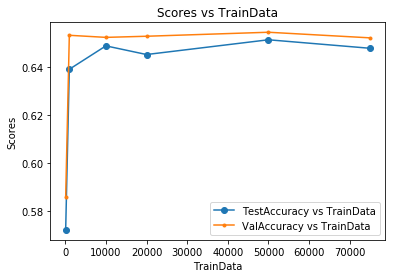

In [22]:
accuracyVisualization(train_samples,val_accuracies,test_accuracies)

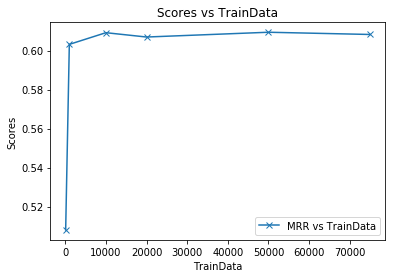

In [23]:
mrrVisualization(train_samples,mrr_vals)

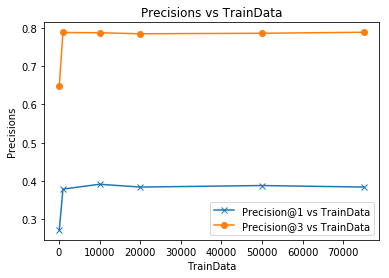

In [24]:
precisionVisualization(train_samples,p1s,p3s)

In [25]:
val_accuracies,test_accuracies,mrr_vals,p1s,p3s


([0.5858,
  0.6532,
  0.6523333333333333,
  0.6528,
  0.6544666666666666,
  0.6521333333333333],
 [0.5722666666666667,
  0.6390666666666667,
  0.6488,
  0.6452,
  0.6513333333333333,
  0.6478],
 [0.5080000000000019,
  0.603190476190479,
  0.6091814814814851,
  0.6069592592592625,
  0.6094126984127012,
  0.608268253968257],
 [0.272, 0.37866666666666665, 0.3913333333333333, 0.384, 0.388, 0.384],
 [0.6493333333333333,
  0.788,
  0.7873333333333333,
  0.7846666666666666,
  0.786,
  0.7886666666666666])